In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

/Users/mengjiayu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df = pd.read_csv('output_dataset.csv')

In [4]:
whole = df[['Total Bilirubin', 'Alkphos Alkaline Phosphotase',
'Sgpt Alamine Aminotransferase', 'Sgot Aspartate Aminotransferase',
'Total Protiens', 'ALB Albumin', 'A/G Ratio Albumin and Globulin Ratio',
'Bilirubin Ratio', 'SGOT/SGPT Ratio', 'Protien Ratio', 'Result']]

In [5]:
whole

,Total Bilirubin,Alkphos Alkaline Phosphotase,Sgpt Alamine Aminotransferase,Sgot Aspartate Aminotransferase,Total Protiens,ALB Albumin,A/G Ratio Albumin and Globulin Ratio,Bilirubin Ratio,SGOT/SGPT Ratio,Protien Ratio,Result
0,0.530628,187.0,2.833213,2.944439,6.8,3.3,0.90,0.179618,1.039258,0.485294,1
1,2.476538,690.0,4.174387,4.615121,7.5,3.2,0.74,0.755814,1.105580,0.426667,1
2,2.116256,490.0,4.110874,4.234107,7.0,3.3,0.89,0.769869,1.029977,0.471429,1
3,0.693147,182.0,2.772589,3.044522,6.8,3.4,1.00,0.485427,1.098079,0.500000,1
4,1.589235,195.0,3.332205,4.094345,7.3,2.4,0.50,0.691284,1.228719,0.328767,1
...,...,...,...,...,...,...,...,...,...,...,...
30686,1.163151,610.0,2.890372,3.367296,7.3,2.6,0.55,0.595922,1.165004,0.356164,1
30687,1.360977,482.0,3.135494,3.555348,7.0,2.4,0.50,0.611994,1.133904,0.342857,1
30688,2.054124,542.0,4.762174,4.204693,6.4,3.1,0.90,0.674884,0.882936,0.484375,1
30689,1.064711,231.0,2.833213,4.025352,4.6,1.8,0.60,0.651019,1.420773,0.391304,1


In [6]:
# Prepare features and target variable
feature_cols = ['Total Bilirubin', 'Alkphos Alkaline Phosphotase',
                'Sgpt Alamine Aminotransferase', 'Sgot Aspartate Aminotransferase',
                'Total Protiens', 'ALB Albumin', 'A/G Ratio Albumin and Globulin Ratio',
                'Bilirubin Ratio', 'SGOT/SGPT Ratio', 'Protien Ratio']

X = df[feature_cols]
y = df['Result']

# Convert target labels: 2 → 0 (Non-Disease), 1 → 1 (Disease)
y = (y == 1).astype(int)

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize Numeric Features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Compute Correct Class Weights
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}  # Ensure only 0 and 1 keys

# Function to Build FNN Model
def build_fnn_model(hidden_units=128, dropout_rate=0.3, learning_rate=0.001):
    model = keras.Sequential([
        keras.layers.Dense(hidden_units, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(hidden_units // 2, activation='relu'),
        keras.layers.Dense(hidden_units // 4, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')  # Binary classification output
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter tuning with Stratified K-Fold Cross Validation
best_model = None
best_score = 0
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for units in [64, 128, 256]:  # Wider range of neurons
    for dropout in [0.1, 0.3, 0.5]:  # More dropout variations
        for lr in [0.001, 0.0005, 0.0001]:  # Test higher and lower learning rates
            fold_scores = []
            
            for train_idx, val_idx in kf.split(X_train, y_train):
                X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
                y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
                
                model = build_fnn_model(hidden_units=units, dropout_rate=dropout, learning_rate=lr)
                
                # Add Early Stopping to prevent overfitting
                early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

                history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0, 
                                    validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], 
                                    class_weight=class_weights_dict)

                val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
                fold_scores.append(val_acc)
            
            avg_score = np.mean(fold_scores)
            print(f"Units: {units}, Dropout: {dropout}, LR: {lr} -> Avg Val Accuracy: {avg_score:.4f}")
            
            if avg_score > best_score:
                best_score = avg_score
                best_model = model  # Save the best model dynamically

# Train the best model on full training data 
print("\n Best Model Found - Training on Full Training Data...")
final_model = best_model

history = final_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test),
                          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)], 
                          class_weight=class_weights_dict)


Units: 64, Dropout: 0.1, LR: 0.001 -> Avg Val Accuracy: 0.9695
Units: 64, Dropout: 0.1, LR: 0.0005 -> Avg Val Accuracy: 0.9744
Units: 64, Dropout: 0.1, LR: 0.0001 -> Avg Val Accuracy: 0.8991
Units: 64, Dropout: 0.3, LR: 0.001 -> Avg Val Accuracy: 0.9457
Units: 64, Dropout: 0.3, LR: 0.0005 -> Avg Val Accuracy: 0.9375
Units: 64, Dropout: 0.3, LR: 0.0001 -> Avg Val Accuracy: 0.8414
Units: 64, Dropout: 0.5, LR: 0.001 -> Avg Val Accuracy: 0.8733
Units: 64, Dropout: 0.5, LR: 0.0005 -> Avg Val Accuracy: 0.8753
Units: 64, Dropout: 0.5, LR: 0.0001 -> Avg Val Accuracy: 0.7628
Units: 128, Dropout: 0.1, LR: 0.001 -> Avg Val Accuracy: 0.9869
Units: 128, Dropout: 0.1, LR: 0.0005 -> Avg Val Accuracy: 0.9841
Units: 128, Dropout: 0.1, LR: 0.0001 -> Avg Val Accuracy: 0.9621
Units: 128, Dropout: 0.3, LR: 0.001 -> Avg Val Accuracy: 0.9845
Units: 128, Dropout: 0.3, LR: 0.0005 -> Avg Val Accuracy: 0.9810
Units: 128, Dropout: 0.3, LR: 0.0001 -> Avg Val Accuracy: 0.9359
Units: 128, Dropout: 0.5, LR: 0.001 -> 

In [ ]:
# Units: 256, Dropout: 0.1, LR: 0.0005 -> Avg Val Accuracy: 0.9873

In [7]:
final_model.summary()

Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_396 (Dense)           (None, 256)               2816      
                                                                 
 batch_normalization_99 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_99 (Dropout)        (None, 256)               0         
                                                                 
 dense_397 (Dense)           (None, 128)               32896     
                                                                 
 dense_398 (Dense)           (None, 64)                8256      
                                                                 
 dense_399 (Dense)           (None, 1)                 65        
                                                     

In [8]:
# Save the Final Model
final_model.save("fnn_model.h5")

/Users/mengjiayu/opt/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# Get Final Training Accuracy (Last Epoch)
train_accuracy = history.history['accuracy'][-1]

# Get Mean Cross-Validation Accuracy from Best Model
cv_accuracy = best_score  

accuracy_df = pd.DataFrame({
    "Metric": ["Train Accuracy", "Mean CV Accuracy"],
    "Value": [train_accuracy, cv_accuracy]
})

accuracy_df

,Metric,Value
0,Train Accuracy,0.986030
1,Mean CV Accuracy,0.987251


192/192 [==============================] - 0s 713us/step

 Model Evaluation Metrics:
      Metric     Value
0   Accuracy  0.987946
1  Precision  0.992234
2     Recall  0.990876
3   F1 Score  0.991554
4    ROC-AUC  0.996445

 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1755
           1       0.99      0.99      0.99      4384

    accuracy                           0.99      6139
   macro avg       0.98      0.99      0.99      6139
weighted avg       0.99      0.99      0.99      6139



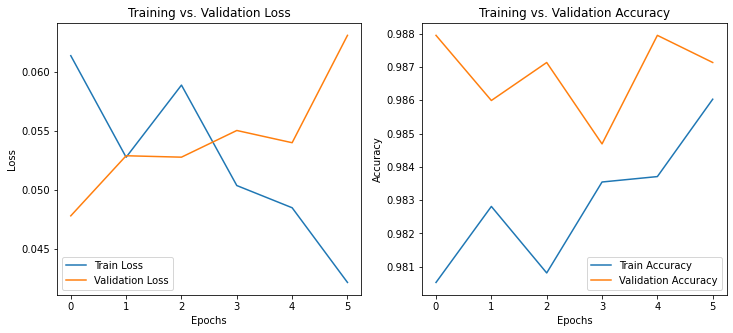

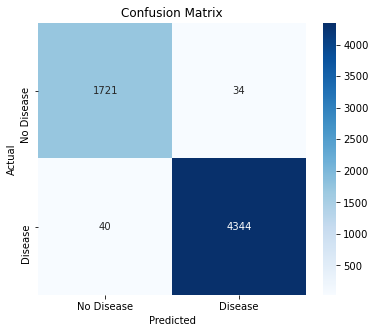

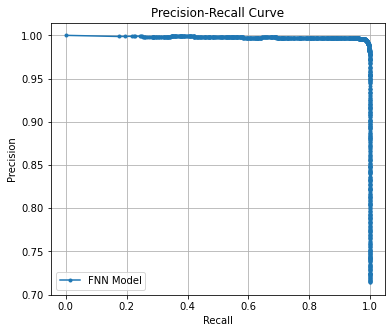

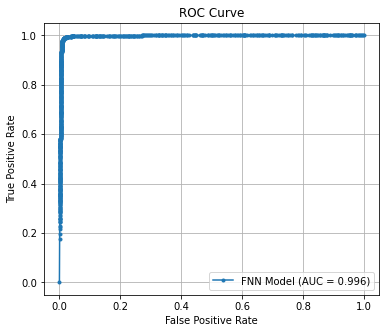

In [9]:
# Model Testing (Predictions)
y_pred_prob = final_model.predict(X_test)  # Get probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to class labels

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print Evaluation Results in Tabular Form
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"],
    "Value": [accuracy, precision, recall, f1, roc_auc]
})
print("\n Model Evaluation Metrics:")
print(metrics_df)

# Classification Report
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Plot Metrics Curves (Loss & Accuracy)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(6,5))
plt.plot(recall_vals, precision_vals, marker='.', label="FNN Model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, marker='.', label=f"FNN Model (AUC = {roc_auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


In [ ]:
'''# Load the saved model
from tensorflow.keras.models import load_model

loaded_model = load_model("fnn_model.h5")

loaded_model.summary()
'''